## Executive Summary
We will explore and analyze data collected from Twitter via its (Public) streaming API. Particularly, we track certain users (stock traders), which we refer to as *agents* from this point forward, who tweet a lot about the Philippine market. The tweets need not come from the *agents* themselves. If the tweets contain their screen names (Twitter handle), then these are collected as well.

We first look at the temporal dynamics of the tweets by plotting the number of tweets as a function of time. This is to establish that the *agents* are tweeting more when the Philippine market opens. The Philippine Stock Exchange (PSE) opens from 9:30 AM - 12:00 PM, and then in the afternoon, from 1:30PM to 3:30PM. We will also uncover some network structure that would quantify the "influence" of our agents. As an exploratory process, we first look at the retweet network whereby we are assuming that the more an agent's tweet is retweeted the more influential that finance person is. Finally, we look at specific tweets on specific securities, only as a proof of concept, to show whether or not the number of tweets on a security can be a proxy to the traded volume of the specific stock. In this section of the project, we will make use of open data on the Philippine Stock Market. 

## Importing Packages

In [1]:
import pandas as pd
import sqlite3 as sq
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import re
from graph_tool.all import *
import networkx as nx
import numpy as np
%matplotlib inline

## Loading the Data
Here, we load the .sqlite file that we used to store the Twitter data we collected using Twitter's Public API. 

In [2]:
con = sq.connect("TradersPH.sqlite")
df = pd.read_sql('''SELECT * FROM TWEET''', con)

### Fix time columns
Since the `CREATED_AT` column loaded is `str`, we need to convert it to datetime for ease in sorting and selecting of data later.

In [3]:
def fixtime(mydate):
    dt = datetime.strptime(mydate, '%a %b %d %H:%M:%S +0000 %Y')
    dt = dt + timedelta(hours=8) #Philippine time
    return dt

df["CREATED_AT"] = df.apply(lambda row: fixtime(row["CREATED_AT"]), axis = 1)

## Data Exploration
### Time Series Analysis

In [4]:
df = df.sort(["CREATED_AT"])
start = list(df.head(n=1).CREATED_AT)[0]
end = list(df.tail(n=1).CREATED_AT)[0]

In [5]:
print type(start), end

<class 'pandas.tslib.Timestamp'> 2015-10-30 10:58:41


Here, we focus on the time frame from 01 October 2015 to 25 October 2015.

In [6]:
start = datetime(2015,10,1,0,0,0)
end = datetime(2015,10,25,0,0,0)

def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta
        
tick = []      
for result in perdelta(start, end, timedelta(seconds=(1*3600))):
    tick.append(result)

tick2 = []
for result in perdelta(start, end, timedelta(days=1)):
    tick2.append(result)
    
interval = []
for v, w in zip(tick[:-1], tick[1:]):
    interval.append([v, w])

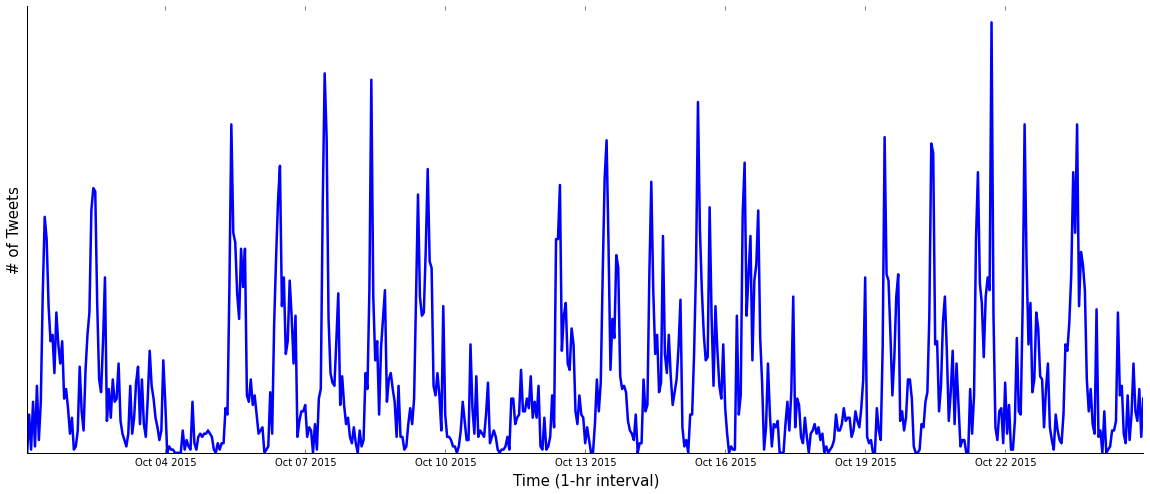

In [7]:
#plt.xkcd()
plt.clf()
freq = []
for i in interval:
    begin, end = i[0], i[1]
    temp = df[(df['CREATED_AT'] > begin) & (df['CREATED_AT'] <= end) ]
    freq.append(len(temp))
        
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(tick[1:],freq, '-', lw=2.5)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.yticks([])
ax.set_ylabel("# of Tweets", fontsize=15)
ax.set_xlabel("Time (1-hr interval)", fontsize=15)
plt.show()

We can roughly see some periodicity. On a more macro level, we see a series of five "spikes", which is followed by two plataues, which is subsequently followed by another set of five spikes. The plot suggests that traders are truly "live" tweeting (5 peaks--weekdays) whenever the market opens. This supports the idea that we might actually seem some correlation in sentiments of the tweets of certain Twitter users on a specific security, given a security. 

We zoom in to a two weeks' worth of data to highlight the specific hours when the market is open.

In [8]:
start = datetime(2015,10,10,0,0,0)
end = datetime(2015,10,25,0,0,0)

def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta
        
tick = []      
for result in perdelta(start, end, timedelta(seconds=(2*3600))):
    tick.append(result)

tick2 = []
for result in perdelta(start, end, timedelta(days=1)):
    tick2.append(result)
    
interval = []
for v, w in zip(tick[:-1], tick[1:]):
    interval.append([v, w])

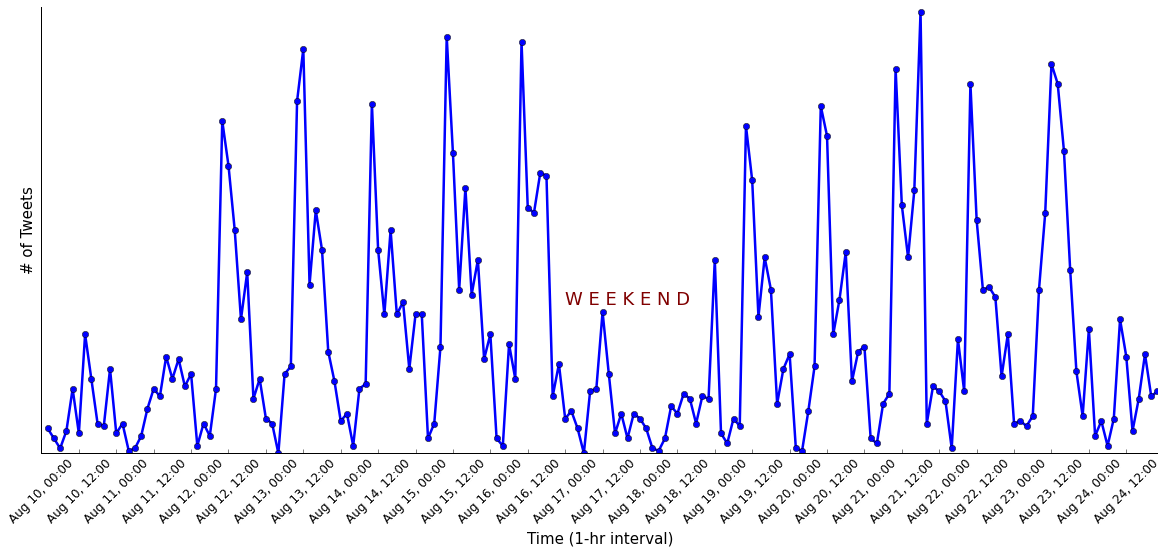

In [9]:
freq = []
for i in interval:
    begin, end = i[0], i[1]
    temp = df[(df['CREATED_AT'] > begin) & (df['CREATED_AT'] <= end) ]
    freq.append(len(temp))
        
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(tick[1:],freq, 'o-', lw=2.5)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

xticks = range(0,len(tick[1:]),6)
xtcklab = [tick[x] for x in xticks]
xtickstring = [dr.strftime("Aug %d, %H:%M") for dr in xtcklab]

ax.set_xticks(xtcklab)
ax.set_xticklabels(xtickstring, fontsize=12)
plt.setp(plt.xticks()[1], rotation=45)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.text(datetime(2015,10,17,0,0,0),60,'W E E K E N D', fontsize=18, color = 'maroon')

plt.yticks([])
ax.set_ylabel("# of Tweets", fontsize=15)
ax.set_xlabel("Time (1-hr interval)", fontsize=15)
plt.show()

In this plot, we see the same trend that we saw in the previous one but we see a more pronounced dip at the 12:00 noon mark of each weekday. This is because at that time, the market is in recess. Market resumes at 1:30PM on weekdays.

### Twitter User Network: The Influencers

In [10]:
user_tweets = df[["USER_SCREEN_NAME","TWEET"]]
user_tweets.head()

,USER_SCREEN_NAME,TWEET
0,elianna0823,RT @itradeph: PSEi 7350.06 +5.83 pts. +0.08%. ...
1,Philbizwatcher,SEC oks P7.7B initial public offering of housi...
2,marcguevara13,RT @Philbizwatcher: SEC oks P7.7B initial publ...
3,Philbizwatcher,Profriends : summary of IPO terms as approved ...
4,pnoytrader,RT @ArabianBusiness: Revealed: The most and le...


In [11]:
edge = []
r = re.compile(r"([@$])(\w+)\b")
count = 0

for ind, row in user_tweets.iterrows():
    tweet = row.TWEET
    if tweet[0:3] == "RT ":
        tagged = r.findall(tweet)
        try:
            edge.append([str(tagged[0][1]), str(row.USER_SCREEN_NAME)])
        except:
            pass

In [12]:
edge[0:10]

[['itradeph', 'elianna0823'],
 ['Philbizwatcher', 'marcguevara13'],
 ['ArabianBusiness', 'pnoytrader'],
 ['Philbizwatcher', 'pnoytrader'],
 ['Philbizwatcher', 'pnoytrader'],
 ['gus_cosio', 'jethronalejo'],
 ['Pizza_Trader', 'dafOfO'],
 ['Pizza_Trader', 'dafOfO'],
 ['EM_Equity', 'DennyCrane550'],
 ['AprilLeeTan', 'daytripper1021']]

In [13]:
G = nx.DiGraph()
G.add_edges_from(edge)
nx.write_graphml(G, "traders.graphml")
g = load_graph("traders.graphml")

In [14]:
gc = GraphView(g, vfilt=label_largest_component(g, directed=True)).copy()
gc.purge_vertices()
indeg = gc.degree_property_map("out")
indeg.a = np.sqrt(indeg.a)+2
graph_draw(gc, vertex_size = indeg, vertex_fill_color=indeg, pos = sfdp_layout(gc),
           vcmap=plt.cm.gist_heat, output_size=(800, 800), output="gc.png")


<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12ab14310, at 0x12aaed310>

### Focus on Specific Securities

In [15]:
df_stock = df[df["TWEET"].str.contains("DNL ", flags = re.IGNORECASE)]

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/frame.py:1815: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


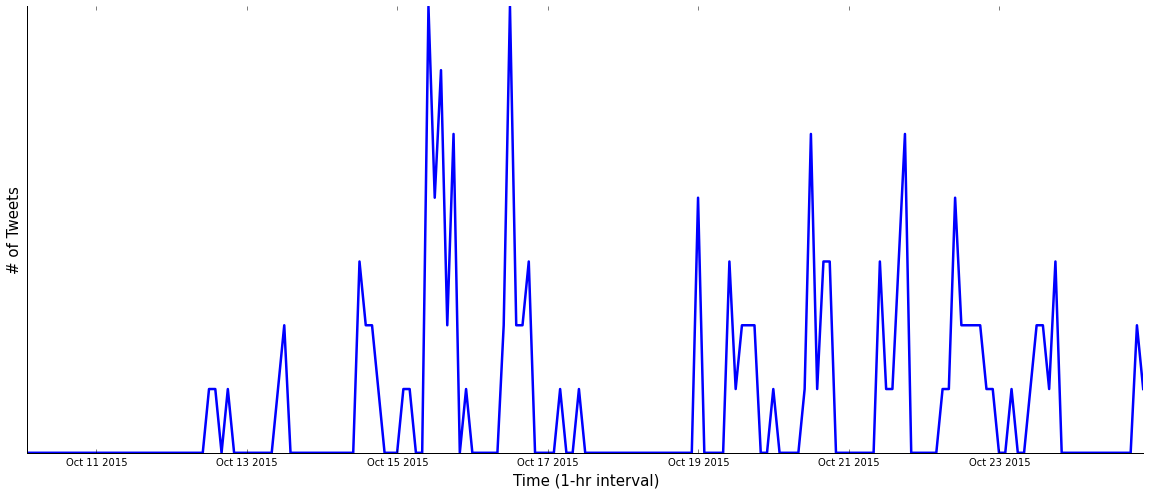

In [16]:
plt.clf()
freq = []
for i in interval:
    begin, end = i[0], i[1]
    temp = df_stock[(df['CREATED_AT'] > begin) & (df_stock['CREATED_AT'] <= end) ]
    freq.append(len(temp))
        
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(tick[1:],freq, '-', lw=2.5)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.yticks([])
ax.set_ylabel("# of Tweets", fontsize=15)
ax.set_xlabel("Time (1-hr interval)", fontsize=15)
plt.show()

In [17]:
df_stock_zoom = df_stock[(df_stock.CREATED_AT > datetime(2015,10,7,0,0,0)) & 
                    (df_stock.CREATED_AT < datetime(2015,10,8,0,0,0))]

In [18]:
quotes = "PSE_quotes.sqlite"
con = sq.connect(quotes)
quotes = pd.read_sql('''SELECT * FROM Quotes''', con)
con.close()

In [19]:
mystock = "DNL"
stockfocus = quotes[quotes.STOCK_SYMBOL==mystock.strip()]
stockfocus.head()

,ENTRY_INDEX,DATE,STOCK_SYMBOL,STOCK_TYPE,VOLUME,OPEN,HIGH,LOW,CLOSE
273027,273028,2012-12-12,DNL,Company,68451000,4.38,4.51,4.34,4.36
273246,273247,2012-12-13,DNL,Company,28146000,4.34,4.45,4.32,4.44
273463,273464,2012-12-14,DNL,Company,27942000,4.44,4.55,4.41,4.47
273684,273685,2012-12-17,DNL,Company,8524000,4.50,4.50,4.41,4.42
273906,273907,2012-12-18,DNL,Company,12263000,4.45,4.50,4.38,4.43


In [20]:
def convertDT(dt):
    try:
        #return datetime.strptime(dt, '%Y-%m-%d %H:%M:%S.000000')
        return datetime.strptime(dt, '%Y-%m-%d')
    except:
        return None

In [21]:
stockfocus["DATE"] = stockfocus.apply(lambda row: convertDT(row["DATE"]), axis = 1)
stockfocus.head()

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,ENTRY_INDEX,DATE,STOCK_SYMBOL,STOCK_TYPE,VOLUME,OPEN,HIGH,LOW,CLOSE
273027,273028,2012-12-12,DNL,Company,68451000,4.38,4.51,4.34,4.36
273246,273247,2012-12-13,DNL,Company,28146000,4.34,4.45,4.32,4.44
273463,273464,2012-12-14,DNL,Company,27942000,4.44,4.55,4.41,4.47
273684,273685,2012-12-17,DNL,Company,8524000,4.50,4.50,4.41,4.42
273906,273907,2012-12-18,DNL,Company,12263000,4.45,4.50,4.38,4.43


In [22]:
stockfocus_sub = stockfocus[(stockfocus.DATE > datetime(2015,9,30,0,0,0)) & 
                            (stockfocus.DATE < datetime(2015,11,1,0,0,0) )]

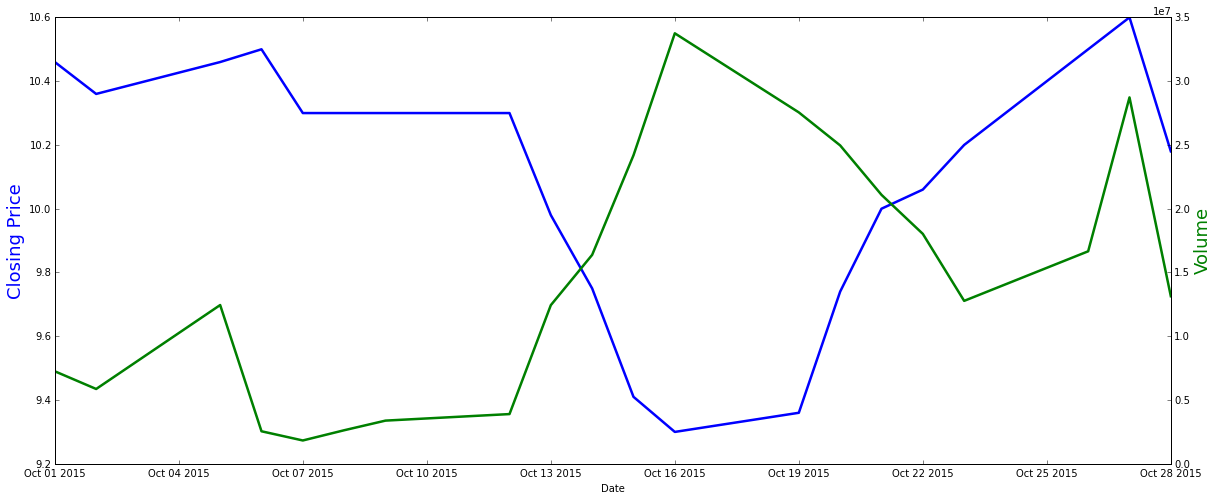

In [23]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(stockfocus_sub.DATE,stockfocus_sub.CLOSE, color="blue", lw=2.5)
ax.set_ylabel("Closing Price", color="blue", fontsize=18)
ax2 = ax.twinx()
ax2.plot(stockfocus_sub.DATE,stockfocus_sub.VOLUME,color="green", lw=2.5)
ax2.set_ylabel("Volume", color="green", fontsize=18)
ax.set_xlabel("Date")